## ひらがな手書きの文字認識

### データのダウンロード（NDL LABからひらがなのデータ）

In [2]:
%matplotlib inline

In [3]:
notebook_id = %env TRAINING_NOTEBOOK_ID
%cd '/mnt/notebooks/{notebook_id}/Platform_handson/hiragana_classify'

/mnt/notebooks/1744340654389/Platform_handson/hiragana_classify


In [4]:
# home配下にdataを配置する
!wget http://lab.ndl.go.jp/dataset/hiragana73.zip -P /home/data

--2019-04-22 08:35:43--  http://lab.ndl.go.jp/dataset/hiragana73.zip
Resolving lab.ndl.go.jp (lab.ndl.go.jp)... 202.32.173.150
Connecting to lab.ndl.go.jp (lab.ndl.go.jp)|202.32.173.150|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://lab.ndl.go.jp/dataset/hiragana73.zip [following]
--2019-04-22 08:35:43--  https://lab.ndl.go.jp/dataset/hiragana73.zip
Connecting to lab.ndl.go.jp (lab.ndl.go.jp)|202.32.173.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233312433 (223M) [application/zip]
Saving to: ‘/home/data/hiragana73.zip.1’

hiragana73.zip.1    100%[===================>] 222.50M  11.0MB/s    in 23s     

2019-04-22 08:36:06 (9.63 MB/s) - ‘/home/data/hiragana73.zip.1’ saved [233312433/233312433]



In [5]:
n_files = !unzip -l /home/data/hiragana73.zip | grep .png | wc -l
!unzip -o /home/data/hiragana73.zip -d /home/data/ | pv -l -s {n_files[0]} > /dev/null

  80k 0:00:13 [6.02k/s] [====================================>] 100%            


In [6]:
ls -al /home/data/hiragana73

total 4676
drwxr-xr-x 75 root root  4096 Sep  8  2016 ./
drwxr-xr-x  3 root root    70 Apr 22 08:35 ../
drwxr-xr-x  2 root root 45056 Apr 22 08:36 U3042/
drwxr-xr-x  2 root root 45056 Apr 22 08:36 U3044/
drwxr-xr-x  2 root root 45056 Apr 22 08:36 U3046/
drwxr-xr-x  2 root root 40960 Apr 22 08:36 U3048/
drwxr-xr-x  2 root root 49152 Apr 22 08:36 U304A/
drwxr-xr-x  2 root root 49152 Apr 22 08:36 U304B/
drwxr-xr-x  2 root root 45056 Apr 22 08:36 U304C/
drwxr-xr-x  2 root root 45056 Apr 22 08:36 U304D/
drwxr-xr-x  2 root root 40960 Apr 22 08:36 U304E/
drwxr-xr-x  2 root root 49152 Apr 22 08:36 U304F/
drwxr-xr-x  2 root root 40960 Apr 22 08:36 U3050/
drwxr-xr-x  2 root root 45056 Apr 22 08:36 U3051/
drwxr-xr-x  2 root root 40960 Apr 22 08:36 U3052/
drwxr-xr-x  2 root root 45056 Apr 22 08:36 U3053/
drwxr-xr-x  2 root root 40960 Apr 22 08:36 U3054/
drwxr-xr-x  2 root root 49152 Apr 22 08:36 U3055/
drwxr-xr-x  2 root root 40960 Apr 22 08:36 U3056/
drwxr-xr-x  2 root root 49152 Apr 22 08:36 U30

In [7]:
# フォルダの一覧を取得する(hiragana73配下)
import os
path = "/home/data/hiragana73/"
folder = os.listdir(path)
# フォルダは Unicode 表記の平仮名なので、50音順になるように sort しておく
folder.sort()

### 前処理

In [8]:
import glob
import numpy as np
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

image_size = 48
 
X = []
Y = []

for index, name in tqdm(enumerate(folder), total=len(folder)):
    pattern = os.path.join(path, name, '*.png')
    for file in glob.glob(pattern):
      image = Image.open(file)
      image = image.convert("RGB")
      #image = image.convert('L')
      image = image.resize((image_size, image_size))
      data = np.asarray(image)
      X.append(data)
      Y.append(index)
 
# 学習とテストで 8:2 のデータ割合に分ける
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(X), np.array(Y),
    train_size=0.8, test_size=0.2)

In [9]:
# ラベルと対象データを確認
Y_train[1]

44

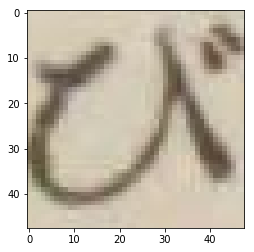

In [10]:
import matplotlib.pyplot as plt
im_list = np.asarray(X_train[1])
plt.imshow(im_list)
plt.show()

In [11]:
# trainとtestがデータが分割されていることを確認する
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

64000
64000
16000
16000


In [12]:
# 0-255の整数値を0〜1の小数に変換する(正規化)
X_train_orig = X_train
X_test_orig = X_test
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [13]:
# one-hot vector形式に変換する
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 73)
Y_test = np_utils.to_categorical(Y_test, 73)

Using TensorFlow backend.


In [14]:
# モデルの定義（別資料にて説明）
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(73, activation='softmax'))

In [15]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [16]:
history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 64000 samples, validate on 16000 samples
Epoch 1/20
64000/64000 [==============================] - 18s 278us/step - loss: 4.2088 - acc: 0.0287 - val_loss: 3.7983 - val_acc: 0.1346
Epoch 2/20
64000/64000 [==============================] - 16s 243us/step - loss: 2.3531 - acc: 0.3917 - val_loss: 0.8017 - val_acc: 0.8437
Epoch 3/20
64000/64000 [==============================] - 16s 244us/step - loss: 0.8786 - acc: 0.7580 - val_loss: 0.3143 - val_acc: 0.9282
Epoch 4/20
64000/64000 [==============================] - 16s 244us/step - loss: 0.4946 - acc: 0.8640 - val_loss: 0.2031 - val_acc: 0.9501
Epoch 5/20
64000/64000 [==============================] - 16s 244us/step - loss: 0.3424 - acc: 0.9066 - val_loss: 0.1449 - val_acc: 0.9629
Epoch 6/20
64000/64000 [==============================] - 16s 242us/step - loss: 0.2658 - acc: 0.9279 - val_loss: 0.1146 - val_acc: 0.9696
Epoch 7/20
64000/64000 [==============================] - 16s 243us/step - loss: 0.2156 - acc: 0.9399 - val_loss: 0.

In [17]:
predict = model.predict(X_test)

In [18]:
len(predict)

16000

In [19]:
# ラベルの設定
label = ["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]

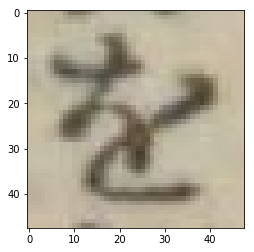

In [20]:
import matplotlib.pyplot as plt
ind = 5542
im_list = np.asarray(X_test_orig[ind])
plt.imshow(im_list)
plt.show()

In [21]:
label[predict[ind].tolist().index(max(predict[ind]))]

'を'

In [22]:
#モデルの保存
model.save('./model/hiragana_model.h5', include_optimizer=False)

In [23]:
from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

jpg_name = ''

model=load_model('./model/hiragana_model.h5')

img_path = ('./sample/test2.png')
img = img_to_array(load_img(img_path, target_size=(48,48)))
img_nad = img_to_array(img)/255
img_nad = img_nad[None, ...]

label=["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]
pred = model.predict(img_nad, batch_size=1, verbose=0)
score = np.max(pred)
pred_label = label[np.argmax(pred[0])]
print('name:',pred_label)
print('score:',score)

name: う
score: 0.9935175


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [24]:
#間違いの一覧を出力する
for ind in range(len(X_test)):
    predict_index = predict[ind].tolist().index(max(predict[ind]))
    answer_index = Y_test[ind].tolist().index(max(Y_test[ind]))
    if predict_index != answer_index:
        print("==========================================")
        print("index番号 : " + str(ind))
        print("推論結果  : " + str(label[predict_index]))
        print("正解　　  : " + str(label[answer_index]))

index番号 : 1
推論結果  : び
正解　　  : ぴ
index番号 : 85
推論結果  : へ
正解　　  : ぺ
index番号 : 107
推論結果  : ば
正解　　  : ぱ
index番号 : 210
推論結果  : ぷ
正解　　  : ぶ
index番号 : 531
推論結果  : ぼ
正解　　  : ぽ
index番号 : 544
推論結果  : と
正解　　  : よ
index番号 : 560
推論結果  : び
正解　　  : ぴ
index番号 : 601
推論結果  : ぐ
正解　　  : く
index番号 : 650
推論結果  : ぺ
正解　　  : べ
index番号 : 658
推論結果  : ぴ
正解　　  : び
index番号 : 718
推論結果  : び
正解　　  : ぴ
index番号 : 760
推論結果  : べ
正解　　  : ぺ
index番号 : 966
推論結果  : す
正解　　  : ず
index番号 : 1006
推論結果  : ほ
正解　　  : ぼ
index番号 : 1030
推論結果  : せ
正解　　  : そ
index番号 : 1127
推論結果  : ぷ
正解　　  : ぶ
index番号 : 1169
推論結果  : ぶ
正解　　  : ぷ
index番号 : 1247
推論結果  : つ
正解　　  : づ
index番号 : 1291
推論結果  : い
正解　　  : ゆ
index番号 : 1304
推論結果  : は
正解　　  : ほ
index番号 : 1364
推論結果  : べ
正解　　  : ぺ
index番号 : 1623
推論結果  : さ
正解　　  : ざ
index番号 : 1631
推論結果  : ぶ
正解　　  : ぷ
index番号 : 1747
推論結果  : ほ
正解　　  : ぽ
index番号 : 1800
推論結果  : べ
正解　　  : ぺ
index番号 : 1894
推論結果  : て
正解　　  : で
index番号 : 1915
推論結果  : ぶ
正解　　  : ぷ
index番号 : 2031
推論結果  : で
正解　　  : て
index番号 : 2178
推論結果  : て
正解　　  : で
i

index番号 : 6680
推論結果  : ざ
正解　　  : き
index番号 : 6752
推論結果  : ぱ
正解　　  : ば
index番号 : 6792
推論結果  : し
正解　　  : じ
index番号 : 6824
推論結果  : ぺ
正解　　  : べ
index番号 : 6939
推論結果  : ぶ
正解　　  : ぷ
index番号 : 7135
推論結果  : ぷ
正解　　  : ぶ
index番号 : 7462
推論結果  : ぼ
正解　　  : ぽ
index番号 : 7499
推論結果  : ば
正解　　  : ぱ
index番号 : 7508
推論結果  : に
正解　　  : じ
index番号 : 7609
推論結果  : び
正解　　  : ぴ
index番号 : 7632
推論結果  : び
正解　　  : ぴ
index番号 : 7646
推論結果  : ぜ
正解　　  : が
index番号 : 7711
推論結果  : ぶ
正解　　  : ぷ
index番号 : 7765
推論結果  : お
正解　　  : ぷ
index番号 : 7823
推論結果  : べ
正解　　  : ぺ
index番号 : 7852
推論結果  : ほ
正解　　  : ぼ
index番号 : 8029
推論結果  : す
正解　　  : ず
index番号 : 8044
推論結果  : あ
正解　　  : わ
index番号 : 8142
推論結果  : ぼ
正解　　  : ぽ
index番号 : 8154
推論結果  : ぱ
正解　　  : ば
index番号 : 8171
推論結果  : て
正解　　  : で
index番号 : 8190
推論結果  : か
正解　　  : り
index番号 : 8199
推論結果  : ぶ
正解　　  : ぷ
index番号 : 8303
推論結果  : ぼ
正解　　  : ぽ
index番号 : 8328
推論結果  : ろ
正解　　  : る
index番号 : 8339
推論結果  : び
正解　　  : ぴ
index番号 : 8586
推論結果  : ら
正解　　  : じ
index番号 : 8593
推論結果  : ば
正解　　  : ぱ
index番号 : 8683
推論結果 

index番号 : 13798
推論結果  : ぱ
正解　　  : ば
index番号 : 13814
推論結果  : ば
正解　　  : ぼ
index番号 : 13849
推論結果  : ぴ
正解　　  : び
index番号 : 13927
推論結果  : ぽ
正解　　  : ぼ
index番号 : 13965
推論結果  : ぱ
正解　　  : ば
index番号 : 13976
推論結果  : び
正解　　  : ぴ
index番号 : 14006
推論結果  : り
正解　　  : わ
index番号 : 14007
推論結果  : ぽ
正解　　  : ぼ
index番号 : 14100
推論結果  : ぶ
正解　　  : ぷ
index番号 : 14340
推論結果  : つ
正解　　  : づ
index番号 : 14392
推論結果  : つ
正解　　  : づ
index番号 : 14405
推論結果  : ぼ
正解　　  : ぽ
index番号 : 14475
推論結果  : ぺ
正解　　  : べ
index番号 : 14550
推論結果  : は
正解　　  : ば
index番号 : 14647
推論結果  : れ
正解　　  : わ
index番号 : 14831
推論結果  : き
正解　　  : ほ
index番号 : 14855
推論結果  : ぶ
正解　　  : ぷ
index番号 : 15074
推論結果  : ど
正解　　  : ぞ
index番号 : 15189
推論結果  : を
正解　　  : ひ
index番号 : 15230
推論結果  : は
正解　　  : ば
index番号 : 15239
推論結果  : も
正解　　  : ゑ
index番号 : 15285
推論結果  : て
正解　　  : で
index番号 : 15326
推論結果  : ぢ
正解　　  : ら
index番号 : 15329
推論結果  : つ
正解　　  : づ
index番号 : 15590
推論結果  : ぴ
正解　　  : び
index番号 : 15661
推論結果  : ぶ
正解　　  : ぷ
index番号 : 15700
推論結果  : に
正解　　  : ご
index番号 : 15740
推論結果  : ぴ
正解

In [25]:
# HTTPサーバに組みこむ際のサンプルコード
from keras.models import load_model
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

model=load_model('./model/hiragana_model.h5')

def process_image(img):
    img = Image.fromarray(img)
    img = img.resize((48, 48)).convert('RGB')
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x, mode='tf')

    label=["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]
    pred = model.predict(x,verbose=0)[0]
    print(pred)
    result_with_labels = [{"label": label[i], "probability": float(score)} for i, score in enumerate(pred)]
    result = {"result":sorted(result_with_labels, key=lambda x: x['probability'], reverse=True)[:5]}

    return result

def handler(iter, context):
    for img in iter:
        yield process_image(img)

In [26]:
#img = Image.open('./test.png')
img = Image.open('./sample/test4.png')
img = np.asarray(img)
process_image(img)

[9.00262021e-05 1.14587658e-12 3.49456386e-05 9.44455147e-01
 4.95602080e-07 4.79736917e-09 2.51969695e-10 2.09284388e-03
 3.44329851e-06 1.88696614e-08 1.05394013e-10 2.91976523e-08
 1.72612651e-12 7.58694387e-06 1.58848110e-07 1.51839064e-04
 7.47595368e-06 1.04687086e-08 6.26422114e-09 3.89618544e-05
 2.59081673e-07 1.05918744e-07 1.26272021e-10 4.04112342e-07
 2.80410278e-10 1.59174829e-06 3.56536045e-09 5.81180529e-06
 3.07426575e-07 8.60953833e-08 1.33975497e-08 1.25524220e-05
 6.35001696e-09 2.73732749e-05 2.47706907e-07 2.58251348e-05
 3.00188208e-09 8.81704598e-10 3.84733312e-08 7.60044330e-08
 3.31805791e-06 1.48465755e-08 1.24945787e-09 6.81987977e-09
 1.02059170e-08 1.21116203e-12 4.61808622e-06 3.78817589e-07
 1.99320809e-08 2.59797673e-07 2.09065820e-06 3.88579878e-07
 9.91099387e-06 3.14784415e-06 1.39232725e-07 5.26245348e-02
 8.46158036e-06 4.38879655e-10 8.98380279e-07 1.48244426e-05
 1.88866381e-10 5.96212038e-11 1.62255401e-05 2.22663093e-05
 1.49155113e-07 2.226989

{'result': [{'label': 'え', 'probability': 0.9444551467895508},
  {'label': 'ま', 'probability': 0.05262453481554985},
  {'label': 'き', 'probability': 0.0020928438752889633},
  {'label': 'る', 'probability': 0.00022269890177994967},
  {'label': 'さ', 'probability': 0.00015183906361926347}]}

この後、modelフォルダに存在するh5ファイルとmain.pyを圧縮し
ABEJA Platform上にアップロードすることで、HTTPサーバとして活用可能

## Imagegeneratorを使う場合(参考程度に記載)

In [27]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
datagen = ImageDataGenerator(rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set test split

In [29]:
dir = '/home/data/hiragana73'
train_generator = datagen.flow_from_directory(
        dir,     # directory
        target_size=(48, 48),     # input shape (resized to 150x150)
        batch_size=20,
        class_mode='categorical')    # categorical labels

Found 80000 images belonging to 73 classes.


In [30]:
test_generator = datagen.flow_from_directory(
    dir, # same directory as training data
    target_size=(48, 48),
    batch_size=20,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 15973 images belonging to 73 classes.


In [31]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(73, activation='softmax'))

from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [32]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=354,
      epochs=20,
      validation_data=test_generator,
      validation_steps=56)

Epoch 1/20
354/354 [==============================] - 5s 14ms/step - loss: 4.2748 - acc: 0.0174 - val_loss: 4.2596 - val_acc: 0.0116
Epoch 2/20
354/354 [==============================] - 4s 12ms/step - loss: 4.2592 - acc: 0.0178 - val_loss: 4.2573 - val_acc: 0.0286
Epoch 3/20
354/354 [==============================] - 4s 12ms/step - loss: 4.2449 - acc: 0.0220 - val_loss: 4.2072 - val_acc: 0.0286
Epoch 4/20
354/354 [==============================] - 4s 12ms/step - loss: 4.1579 - acc: 0.0391 - val_loss: 3.9445 - val_acc: 0.1134
Epoch 5/20
354/354 [==============================] - 4s 12ms/step - loss: 3.8075 - acc: 0.0829 - val_loss: 3.1935 - val_acc: 0.2580
Epoch 6/20
354/354 [==============================] - 4s 12ms/step - loss: 3.3039 - acc: 0.1660 - val_loss: 2.5084 - val_acc: 0.3991
Epoch 7/20
354/354 [==============================] - 4s 12ms/step - loss: 2.7917 - acc: 0.2696 - val_loss: 1.8603 - val_acc: 0.5500
Epoch 8/20
354/354 [==============================] - 4s 12ms/step - 

In [33]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

test_loss, test_acc = model.evaluate_generator(test_generator, steps=54)
print('test loss:', test_loss)
print('test acc:', test_acc)

test loss: 0.41560396552085876
test acc: 0.894444442457623
